In [80]:
#importing required Libraries
import numpy as np
import tensorflow
import keras
import os
import glob
from skimage import io ,color
import skimage
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

## Step 1: Load Dataset

Number of images in class Apple: 294
Number of images in class Avocado: 468
Number of images in class Banana: 169
Number of images in class Blackberrie: 300
Number of images in class Pear: 326


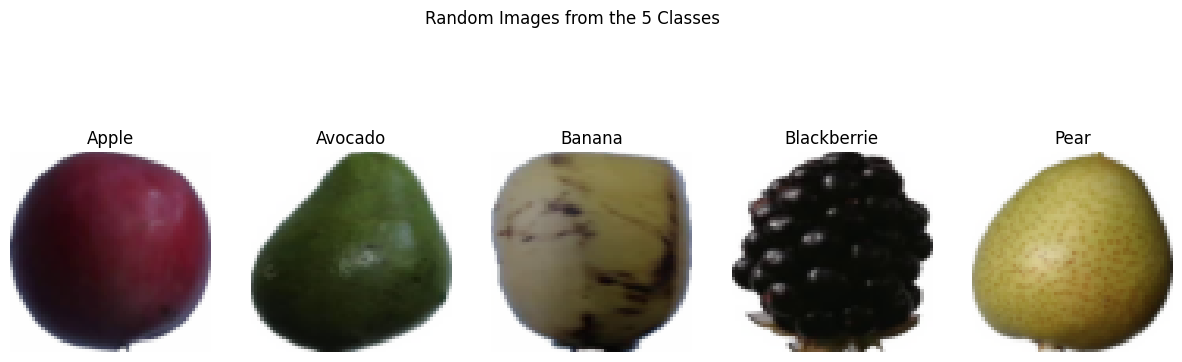

In [81]:
# Define the root directory where images are stored
from skimage.transform import resize
root = r'D:\projects\Project Ai KenKen\DataSetForImages\Training'

classes = ['Apple', 'Avocado', 'Banana', 'Blackberrie', 'Pear']

target_size = (64, 64)

images = {}

for cls in classes:
    images[cls] = []
    classpath = os.path.join(root, cls)
    for img_path in glob.glob(os.path.join(classpath, '*.jpg')):
        img = io.imread(img_path)
        img = resize(img, target_size)
        images[cls].append(img) 

for cls in classes:
    print(f"Number of images in class {cls}: {len(images[cls])}")

# Displaying some random images from the dataset

fig, axes = plt.subplots(1, 5, figsize=(15,5))  

for ax, cls in zip(axes, classes):
    img = images[cls][0] 
    ax.imshow(img)
    ax.set_title(cls)
    ax.axis('off')

fig.suptitle('Random Images from the 5 Classes')
plt.show()



##  Converting RGB Image to Grayscale

Total images in Graydataset: 1557


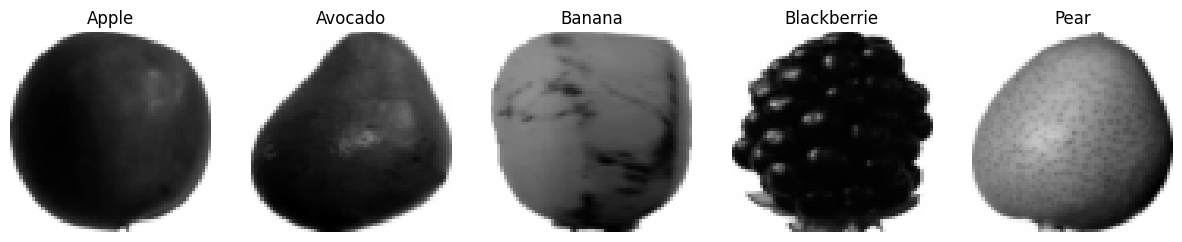

In [82]:
classes = ['Apple', 'Avocado', 'Banana', 'Blackberrie', 'Pear']

Graydataset = []

for cls in classes:
    for img in images.get(cls, []):
        gray_img = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
        Graydataset.append((gray_img, cls))

print(f'Total images in Graydataset: {len(Graydataset)}')
# عرض بعض الصور الرمادية من كل فئة
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
for ax, cls in zip(axes, classes):
    # العثور على أول صورة من الفئة
    for img, label in Graydataset:
        if label == cls:
            ax.imshow(img, cmap='gray')
            ax.set_title(cls)
            ax.axis('off')
            break

##  Histogram Equalization for Contrast Enhancement 


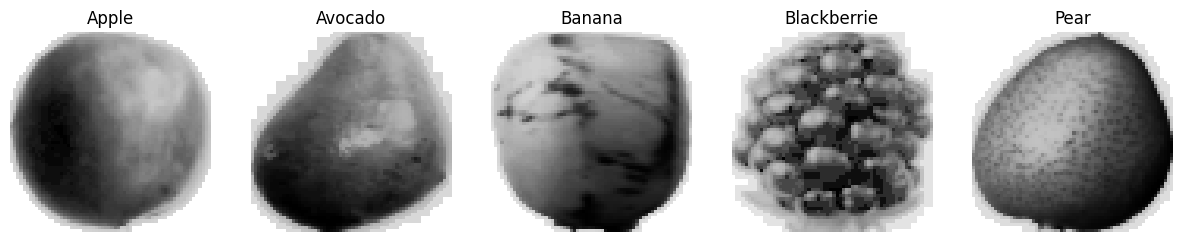

In [83]:
# Histogram Equalization for Contrast Enhancement 
equalized_imgs = [] 
for (img, cls) in Graydataset:
    equalized_img = cv2.equalizeHist(img)
    equalized_imgs.append((equalized_img, cls))


fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax, cls in zip(axes, classes):
    for img, label in equalized_imgs:
        if label == cls:
            ax.imshow(img, cmap='gray')
            ax.set_title(cls)
            ax.axis('off')
            break

## Normalization (Min–Max Scaling)


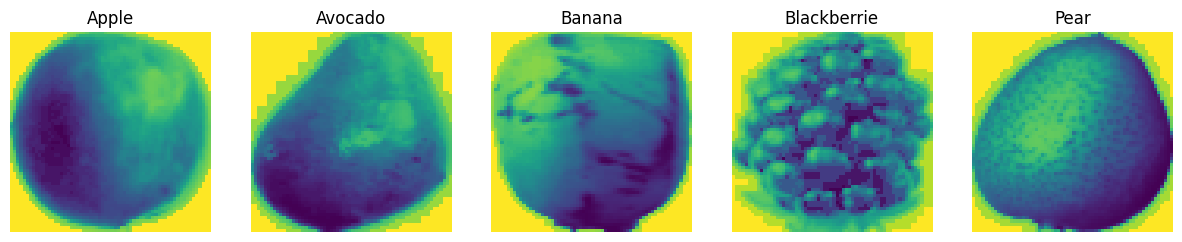

In [84]:
Normalizeddataset = []
for gray_img, cls in equalized_imgs:
    norm_img = (gray_img - np.min(gray_img)) / (np.max(gray_img) - np.min(gray_img))
    Normalizeddataset.append((norm_img, cls))

fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for ax, cls in zip(axes, classes):
    # العثور على أول صورة من الفئة
    for img, label in Normalizeddataset:
        if label == cls:
            ax.set_title(cls)
            ax.imshow(img)
            ax.axis('off')
            break

##  Preparing Image Batch for Data Augmentation


In [85]:
from numpy import expand_dims
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.preprocessing import LabelEncoder

x = np.array([img for img, cls in Normalizeddataset])
y = np.array([cls for img, cls in Normalizeddataset])
le =  LabelEncoder()
y = le.fit_transform(y)


generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True

)


train_gen = generator.flow(
    x.reshape(-1, 64, 64, 1),
    y,
    batch_size=16,
    shuffle=True
)

images_batch, labels_batch = next(train_gen)
print(images_batch.shape)  # (16, H, W, 1)
print(len(images_batch))  #16
print(labels_batch.shape)  # (16, num_classes)

(16, 64, 64, 1)
16
(16,)


## Spliting Data


In [115]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score


N, H, W,  = x.shape
X_flat = x.reshape(N, H*W)  # كل صورة تصبح vector بطول H*W

# Split to train & test
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.25, random_state=0,shuffle=True)
print(X_train.shape)
print(X_test.shape)




(1167, 4096)
(390, 4096)


## Logistic Regression

In [149]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

# show some samples from Normalizeddataset
# import random
# sample_indices = random.sample(range(len(Normalizeddataset)), 20)
# for i in sample_indices:
#     img, cls = Normalizeddataset[i]
#     plt.imshow(img, cmap='gray') 
#     plt.title(f"Class: {cls}") 
#     plt.colorbar() 
#     plt.show()

# Flatten images لكل sample

logreg = LogisticRegression(random_state=0,max_iter=1000)  
logreg.fit(X_train, y_train)

# Cross-validation
scores = cross_val_score(logreg, X_flat, y, cv=5)  # cv=5 يعني 5 folds

print("Accuracy for each fold:",scores)
print("Mean accuracy:", np.mean(scores))
print("Std deviation:", np.std(scores))

# Evaluate
y_pred = logreg.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", acc)


Accuracy for each fold: [1.         0.97435897 0.9903537  0.85530547 0.84565916]
Mean accuracy: 0.9331354604666501
Std deviation: 0.06804966108625593
Logistic Regression Accuracy: 1.0


## KMeans Clustering (Unsupervised)

In [147]:
from sklearn.cluster import KMeans

num_clusters = len(np.unique(y))  # عدد الكلاسات

kmeans = KMeans(num_clusters, random_state=0)

kmeans.fit(X_flat)

cluster_labels = kmeans.labels_

# توزيع الصور على clusters
for i in range(num_clusters):
    print(f"Cluster {i} has {np.sum(cluster_labels == i)} images")



Cluster 0 has 68 images
Cluster 1 has 365 images
Cluster 2 has 736 images
Cluster 3 has 315 images
Cluster 4 has 73 images


In [148]:
from sklearn.metrics import accuracy_score
from scipy.optimize import linear_sum_assignment

import numpy as np

# y_encoded = labels الأصلية بعد LabelEncoder
# cluster_labels = نتائج KMeans

# 1- حساب confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, cluster_labels)

# 2- إيجاد أفضل توافق بين clusters و labels
# باستخدام Hungarian algorithm
row_ind, col_ind = linear_sum_assignment(-cm)  # سالب لأن linear_sum_assignment تبحث عن أقل قيمة
mapping = dict(zip(col_ind, row_ind))

# 3- تحويل cluster labels للأرقام المقابلة للـ true labels
new_labels = np.array([mapping[label] for label in cluster_labels])

# 4- حساب accuracy
acc = accuracy_score(y, new_labels)
print("KMeans Accuracy:", acc)


KMeans Accuracy: 0.630057803468208
